In [1]:
import torch
import matplotlib.pyplot as plt
from torcheval.metrics.functional import binary_precision

In [2]:
BATCH_SIZE = 128
device = 'cuda'

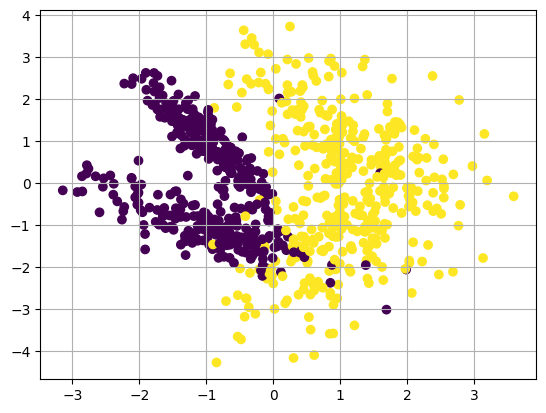

((640, 2), (160, 2))

In [3]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Генерация двумерных данных для бинарной классификации
X_gen, y_gen = make_classification(
    n_samples=800,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=2,
    random_state=33

)

# Визуализация сгенерированных данных
# plt.figure()
plt.scatter(X_gen[:, 0], X_gen[:, 1], c=y_gen)
plt.grid(True)
plt.show()

# Разделение на обучающую и тестовую выборки (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(X_gen, y_gen, test_size=0.2, random_state=42)

# Размерности
X_train.shape, X_test.shape


In [4]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [5]:
train_dataloader = torch.utils.data.DataLoader(CustomDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(CustomDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=True)

In [6]:
class MLP(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(2, 4)
        self.fc2 = torch.nn.Linear(4, 1)
        self.relu = torch.nn.ReLU()
        self.sigm = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigm(x)
        return x

In [7]:
def train_epoch(model_mlp, loss_fn, optimizer, dataloader):
    
    model_mlp.train()
    
    running_loss = 0
    running_metric = 0
    
    for X, y in dataloader:
        optimizer.zero_grad()
        y_pred = model_mlp(X)
        loss = loss_fn(y_pred, y)
        
        running_loss += loss.item()
        running_metric += binary_precision(y_pred.squeeze(), y)
        
        loss.backward()
        optimizer.step()
        
    return running_loss / len(dataloader), running_metric / len(dataloader)

In [8]:
def validate(model_mlp, loss_fn, dataloader):
    
    model_mlp.eval()
    
    running_loss = 0
    running_metric = 0

    with torch.no_grad():
        for X, y in dataloader:
            y_pred = model_mlp(X)
            loss = loss_fn(y_pred, y)
            
            running_loss += loss.item()
            running_metric += binary_precision(y_pred.squeeze(), y)
            
    return running_loss / len(dataloader), running_metric / len(dataloader)

In [9]:
def train(model_mlp, loss_fn, optimizer, train_dataloader, val_dataloader, epochs=10, print_every=1):
    loss_train, loss_val, metric_train, metric_val = [], [], [], []
    for epoch in range(epochs):
        loss_train_epoch, metric_train_epoch = train_epoch(model_mlp, loss_fn, optimizer, train_dataloader)
        loss_val_epoch, metric_val_epoch = validate(model_mlp, loss_fn, val_dataloader)

        # if (epoch + 1) % print_every == 0:
        #     print(f'EPOCH: {epoch+1}')
        #     print(f'TRAIN')
        #     print(f'loss: {loss_train_epoch:.4f} metric: {metric_train_epoch:.4f}')
        #     print(f'VAL')
        #     print(f'loss: {loss_val_epoch:.4f} metric: {metric_val_epoch:.4f}')
        #     print('='*20)
            
        loss_train.append(loss_train_epoch)
        loss_val.append(loss_val_epoch)
        metric_train.append(metric_train_epoch)
        metric_val.append(metric_val_epoch)
        
    return loss_train, loss_val, metric_train, metric_val

In [10]:
model_mlp = MLP()
# model_mlp.to(device)
optimizer = torch.optim.Adam(model_mlp.parameters())
loss_fn = torch.nn.MSELoss()

In [11]:
%%time
loss_train, loss_val, metric_train, metric_val = train(model_mlp, loss_fn, optimizer, train_dataloader, val_dataloader, epochs=1000)

C:\Users\karas\.venv\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\karas\.venv\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


CPU times: total: 55.9 s
Wall time: 14.4 s


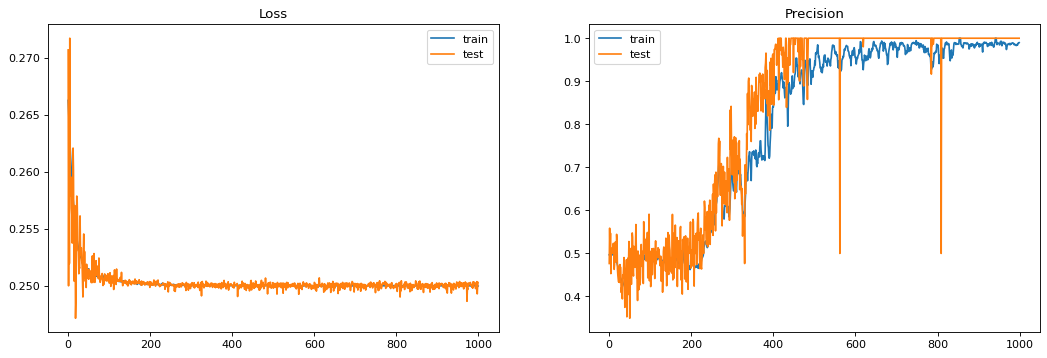

In [12]:
plt.figure(figsize=(16, 5), dpi=80)
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(loss_train)
plt.plot(loss_val)
plt.legend(['train', 'test'])

plt.subplot(1, 2, 2)
plt.title('Precision')
plt.plot(metric_train)
plt.plot(metric_val)
plt.legend(['train', 'test'])